In [ ]:
!pip install python-binance 
!pip install pandas 
!pip install matplotlib 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.2 MB/s 
     |████████████████████████████████| 288 kB 10.8 MB/s 
     |████████████████████████████████| 112 kB 68.1 MB/s 
     |████████████████████████████████| 749 kB 53.8 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')
import numpy as np
#%matplotlib inline
client = Client()

In [ ]:
#HISTORICO 
candles = client.get_klines(symbol='BTCUSDT', interval=Client.KLINE_INTERVAL_1MINUTE, limit = 100)

In [ ]:
len(candles)

100

In [ ]:

price_df = pd.DataFrame(candles, columns=['dateTime',
                                          'open',
                                          'high', 'low',
                                          'close', 'volume',
                                          'closeTime', 
                                          'quoteAssetVolume',
                                          'numberOfTrades', 
                                          'takerBuyBaseVol', 
                                          'takerBuyQuoteVol', 'ignore'])
price_df.dateTime = pd.to_datetime(price_df.dateTime, unit='ms')
price_df.set_index('dateTime')
price_df.closeTime = pd.to_datetime(price_df.closeTime, unit='ms')
price_df.close = pd.to_numeric(price_df.close)




In [ ]:
#price_df.set_index('closeTime', inplace=True)
#closeprice = price_df['close'].to_numpy()

price_df['ma50'] = price_df.close.ewm(span=50).mean()

price_df['ma21'] = price_df.close.ewm(span=21).mean()

price_df.ma50 = pd.to_numeric(price_df.ma50)

price_df.ma21 = pd.to_numeric(price_df.ma21)

price_df.ma50

0     19216.880000
1     19211.479100
2     19207.786484
3     19209.177043
4     19208.669347
          ...     
95    19280.394410
96    19282.734297
97    19286.011671
98    19288.538574
99    19290.898697
Name: ma50, Length: 100, dtype: float64

In [ ]:
#RSI

rsi_period = 14

chg = price_df['close'].diff(1)

gain = chg.mask(chg<0,0)
price_df['gain'] = gain


loss = chg.mask(chg>0,0)
price_df['loss'] = loss

avg_gain = gain.ewm(com = rsi_period-1,min_periods=rsi_period).mean()
avg_loss = loss.ewm(com = rsi_period-1,min_periods=rsi_period).mean()

price_df['avg_gain'] = avg_gain
price_df['avg_loss'] = avg_loss

rs = abs(avg_gain/avg_loss)
rsi = 100 - (100 /(1 + rs) )
rsi



0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
        ...    
95    71.088192
96    64.453792
97    70.609532
98    63.529183
99    62.825678
Name: close, Length: 100, dtype: float64

In [ ]:
## Para el Order Book
def difPct(bid, ask , pr):
  return ((ask - bid )/(pr/100))

client = Client()

order_book = client.futures_order_book(symbol = 'BTCUSDT', limit = 1000)
price_now = client.futures_mark_price(symbol = "BTCUSDT")

order_book = pd.DataFrame(order_book)
bids = pd.DataFrame(order_book['bids'])
asks = pd.DataFrame(order_book['asks'])
#float(asks.head(1)['asks'][0][0])
ask_min = float(asks['asks'].iloc[0][0])
bid_max = float(bids['bids'].iloc[0][0])
price = float(price_now['markPrice'])
dif_pct = difPct(bid_max, ask_min, price)
print( f' price {price} \n Diferencia : {ask_min- bid_max} \n Diferencia PCT: {dif_pct} ' ) 

prices_b = [float(x[0]) for x in order_book['bids']]
prices_a = [float(x[0]) for x in order_book['asks']]
qtts_b = [float(x[1]) for x in order_book['bids']]
qtts_a = [float(x[1]) for x in order_book['asks']]

p_b = pd.to_numeric(prices_b)
p_a = pd.to_numeric(prices_a)
q_b = pd.to_numeric(qtts_b)
q_a = pd.to_numeric(qtts_a)
b_M = q_b.max()
a_M = q_a.max()
bys = []
sls = []
for i in range (0, len(prices_b)) :
  if qtts_b[i] > b_M/4 :
    bys.append(prices_b[i])

for i in range (0, len(prices_a)) :
  if qtts_a[i] > a_M/5 :
    sls.append(prices_a[i])

print(f' compras:{bys} \n ventas: {sls}')


 price 19418.0 
 Diferencia : 0.09999999999854481 
 Diferencia PCT: 0.0005149860953679308 
 compras:[19343.1, 19330.0, 19310.0, 19309.9, 19305.0] 
 ventas: [19450.0, 19488.0, 19490.0, 19500.0, 19520.0]


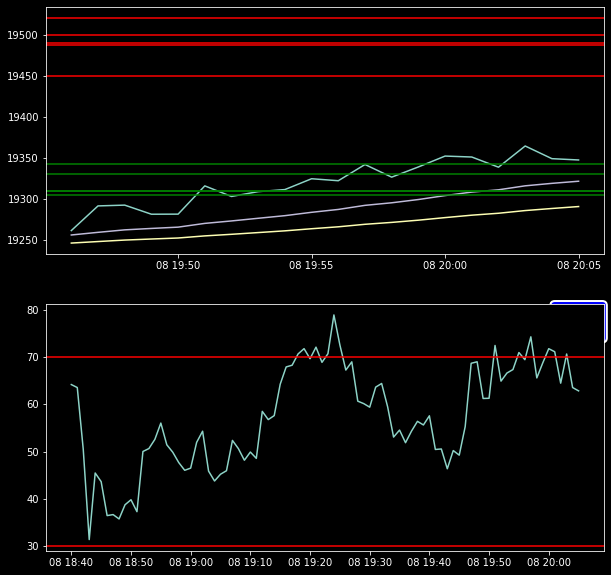

In [ ]:
fig, ax = plt.subplots(2, figsize = (10,10))
ax[0].plot(price_df.closeTime.tail(20),price_df.close.tail(20))
ax[0].plot(price_df.closeTime.tail(20),price_df.ma50.tail(20))
ax[0].plot(price_df.closeTime.tail(20),price_df.ma21.tail(20))
ax[0].text(price_df['closeTime'].tail(1), float(price_df['close'].mean())*0.995, f"Last:\n{int(price_df['close'].tail(1))}", ha="center", va="center", size=15, bbox=dict(boxstyle="round,pad=0.3", fc="blue", ec="w", lw=2))   
for i in sls:
  ax[0].axhline(y=i, color="r")
for i in bys:
  ax[0].axhline(y=i, color="g")
#ax[0].hlines(sls,xmin=float(asks.min()[0][0]), xmax = float(asks.max()[0][0]), color = "r")
#ax[0].hlines(bys,xmin=float(asks.min()[0][0]), xmax = float(asks.max()[0][0]), color = "g")
ax[1].plot(price_df.closeTime,rsi)
ax[1].axhline(y= 30, color = 'r')
ax[1].axhline(y= 70, color = 'r')

In [ ]:
(price_df['closeTime'].tail(1))


99   2022-07-22 18:35:59.999
Name: closeTime, dtype: datetime64[ns]

In [ ]:
for i in rsi.tail(100):
    if (i < 35) :
        print("Compra")
        print('precio:{}')
        print(i)



Compra
precio:{}
33.091017903117546
Compra
precio:{}
31.965430023553708
Compra
precio:{}
29.346025628368096
Compra
precio:{}
33.8016689486296
Compra
precio:{}
33.18233684740174
Compra
precio:{}
31.443531241572757
Compra
precio:{}
32.12108369804761
Compra
precio:{}
29.351125731779092
Compra
precio:{}
28.45943840818711
Compra
precio:{}
30.060542170787357
Compra
precio:{}
33.72021079946707
Compra
precio:{}
32.977857385302116
Compra
precio:{}
31.84273361479768


In [ ]:
price_df['close'].mean()

23014.745699999992